### __Group Project - Predicting Airbnb Listing Prices in Melbourne, Australia__
---

## Fit and tune predictive models, submit predictions & win competition

##### Load the data

In [14]:
import pandas as pd
df_train = pd.read_csv('train_cleaned.csv')
df_test = pd.read_csv('test_cleaned.csv')

To ensure predictive accuracy, the training predictive models are constructed with linear and tree-based base learners.

**Purpose of stacking:**

To leverage diverse learning patterns by combining models that capture both linear relationships (Ridge, Lasso, SVR) and non-linear interactions (LightGBM).

**Linear Models: Feature Selection and Training**
- Models involved: Ridge, Lasso, and SVR.
- Feature selection method:
Applied Recursive Feature Elimination (RFE) with Ridge as the estimator.
- Why Ridge?
  - Handles multicollinearity well.
  - Provides stable, coefficient-based feature importance.
- Optimal subset size:
Selected the top 70 features based on a trade-off between MAE and R² during validation.
- Application:
These 70 features were then used to train and tune the linear models individually before stacking.

**Tree-Based Model: SHAP-Driven Selection**
- Model used: LightGBM
- Feature selection method:
Used SHAP values to rank feature importance specific to LightGBM.
- Optimal subset size:
Chose the top 60 SHAP-ranked features to reduce dimensionality without compromising performance.
- Application:
LightGBM was tuned using these 60 features to optimise non-linear modelling capability.

**Evaluate metric**
- A lower MAE indicates better performance, as predictions are closer to the true values.
- It is expressed in the same unit as the target variable (e.g., price in dollars), making it directly interpretable.

#### **5.1 Linear Models - Hyperparameters Tuning**

In [15]:
import numpy as np
df_train['price_log1p'] = np.log1p(df_train['price'])

In [16]:
# This is to ensure that the result file has the same ID column as the original test set
df_test1 = df_test.copy()

##### **5.1.1 Feature Selection by using Ridge Model**

First, we evaluate how the number of selected features affects **Ridge regression performance.** We first scale all features and use the log-transformed price as the target. Then, for each value of k, we apply Recursive Feature Elimination (RFE) with Ridge as the estimator to select the top k features. Using 5-fold cross-validation, we compute the mean absolute error (MAE) to identify the optimal feature count for the models.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np
X = df_train.drop(columns=['price', 'price_log1p', 'ID'])  # Exclude target and ID

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X = all features
y = df_train['price_log1p']

# Loop to test different feature counts
for k in [20, 30, 40, 50, 70, 60, 80, 90, 100]:
    rfe = RFE(estimator=Ridge(alpha=1.0), n_features_to_select=k)
    rfe.fit(X_scaled, y)
    X_selected = X_scaled[:, rfe.support_]

    score = -np.mean(cross_val_score(Ridge(), X_selected, y, scoring='neg_mean_absolute_error', cv=5))
    print(f"MAE with {k} features: {score:.4f}")

- **70 features** were selected because this count achieved the lowest cross-validated **MAE (0.2834)**.
- The 70-feature setup provided the best balance between model simplicity and accuracy.
- This choice preserves strong predictive power while minimizing unnecessary complexity and the risk of overfitting.

In [18]:
# 1. Scale the features (required for Ridge)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Define Ridge and RFE
ridge = Ridge(alpha=1.0, random_state=42)
rfe = RFE(estimator=ridge, n_features_to_select=70)
rfe.fit(X_scaled, y)

# 3. Get selected features
selected_feature_names = X.columns[rfe.support_]
selected_70 = selected_feature_names.tolist()

In [19]:
# 4. Define seperate dataframe using for linear models
df_train_linear = df_train[selected_70]
df_test_linear = df_test[selected_70]

- As 70 features are selected, the optimal subset is extracted using Recursive Feature Elimination (RFE).
- These selected predictors are used to construct new training and test DataFrames.
- The refined datasets serve as input for ***hyperparameter tuning*** of Ridge, Lasso, and SVR models.
- Ensures all three linear models are trained and evaluated using only **the most relevant** features.
- Improves efficiency and reduces the risk of overfitting by focusing on essential predictors.

##### **5.1.2 Training and Testing Set for Linear Models**

In [20]:
# 1.Creating the train dataset
X_train1 = df_train_linear
y_train1 = df_train['price_log1p'].clip(upper=df_train['price_log1p'].quantile(0.99))

# 2.Creating the test dataset
X_test1 = df_test_linear.copy()

# 3. Creating the scaled training input
sc = StandardScaler()
sc.fit(X_train1)
X_train_scaled = sc.transform(X_train1)
X_test_scaled = sc.transform(X_test1)

- Select **70 features** identified through RFE for use in linear models.
- Clip the target variable at the **99th percentile** to limit the effect of extreme outliers.
- Normalize input features using StandardScaler.
- Normalization is essential for **stable performance** in Ridge, Lasso, and SVR models.

##### **5.1.3 Ridge Tuning**

In [ ]:
# RIDGE:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error


#Defining the parameter grid for tuning hyperparameter alpha
param_grid_rdg = {'alpha':  [1e-15,1e-10,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1,5, 10,15,20,25,30,35,40,45,50,55, 100, 110,120,130,140,150,200]}

#Creating instance of the Ridge model
rdg_model = Ridge()

#Using GridSearch Cross Validation
grid_search_rdg = GridSearchCV(estimator=rdg_model, param_grid=param_grid_rdg, cv=10, scoring='neg_mean_squared_error')
grid_search_rdg.fit(X_train_scaled, y_train1)

#Getting the best model and hyperparameters
best_rdg_model = grid_search_rdg.best_estimator_
best_params_rdg = grid_search_rdg.best_params_
print(best_params_rdg)

# Fit on Full Train Set & Predict on Test
best_rdg_model.fit(X_train_scaled, y_train1)
y_test_pred_log = best_rdg_model.predict(X_test_scaled)
y_test_pred_orig = np.expm1(y_test_pred_log)

# Save Predictions to Keggle Submission Format
df_test_rdg = pd.DataFrame({'ID': df_test1['ID'], 'pre_price': y_test_pred_orig})
df_test_rdg.to_csv('rdg_predicts.csv', index=False)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

# === Custom RMSE Scorer on Original Price Scale ===
def r2_original(y_true_log, y_pred_log):
    return r2_score(np.expm1(y_true_log), np.expm1(y_pred_log))

def mae_original(y_true_log, y_pred_log):
    return mean_absolute_error(np.expm1(y_true_log), np.expm1(y_pred_log))

# rmse_scorer = make_scorer(rmse_original, greater_is_better=False)
r2_scorer = make_scorer(r2_original)
mae_scorer = make_scorer(mae_original, greater_is_better=False)

# Evaluate with 10-fold CV on original scale
# rmse_scores = -cross_val_score(best_lgbm, X_train, y_train, cv=10, scoring=rmse_scorer)
r2_scores = cross_val_score(best_rdg_model, X_train_scaled, y_train1, cv=10, scoring=r2_scorer)
mae_scores = -cross_val_score(best_rdg_model, X_train_scaled, y_train1, cv=10, scoring=mae_scorer)

# print("RMSE (original price scale) of light gbm:", np.mean(rmse_scores))
print("R2 (original price scale) of ridge:", np.mean(r2_scores))
print("MAE (original price scale) of ridge:", np.mean(mae_scores))

##### **5.1.4 Lasso Tuning**

In [ ]:
# LASSO:
from sklearn.linear_model import Lasso

#Defining the parameter grid for tuning hyperparameter alpha levels
param_grid_lso = {'alpha':  [1e-15,1e-10,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1,5, 10,15,20,25,30,35,40,45,50,55,100,110,120,130,140,150,200]}

#Creating instance of the Lasso model
lso_model = Lasso(max_iter=30)

#Using GridSearch Cross Validation
grid_search_lso = GridSearchCV(estimator=lso_model, param_grid=param_grid_lso, cv=10, scoring='neg_mean_squared_error')
grid_search_lso.fit(X_train_scaled, y_train1)

#Getting the best model and hyperparameters
best_lso_model = grid_search_lso.best_estimator_
best_params_lso = grid_search_lso.best_params_
print(best_params_lso)

#Fitting the best model on the training data
best_lso_model.fit(X_train_scaled, y_train1)


# Make predictions and TRANSFORM BACK to original scale
y_pred_lso = best_lso_model.predict(X_test_scaled)
y_pred_lso_orig = np.expm1(y_pred_lso)

#Using fitted model to create price prediction
ID = df_test1['ID']
predicted_prices = y_pred_lso_orig
df_test_las = pd.DataFrame({'ID': ID, 'price': predicted_prices})

#Make into CSV for Kaggle submission
df_test_las[['ID', 'price']].to_csv('lasso_predicts.csv', index=False)

# Step 6: Evaluate on original scale
def r2_original(y_true_log, y_pred_log):
    return r2_score(np.expm1(y_true_log), np.expm1(y_pred_log))

def mae_original(y_true_log, y_pred_log):
    return mean_absolute_error(np.expm1(y_true_log), np.expm1(y_pred_log))


# rmse_scorer = make_scorer(rmse_original, greater_is_better=False)
r2_scorer = make_scorer(r2_original)
mae_scorer = make_scorer(mae_original, greater_is_better=False)

# Evaluate with 10-fold CV on original scale
# rmse_scores = -cross_val_score(best_lgbm, X_train, y_train, cv=10, scoring=rmse_scorer)
r2_scores = cross_val_score(best_lso_model, X_train_scaled, y_train1, cv=10, scoring=r2_scorer)
mae_scores = -cross_val_score(best_lso_model, X_train_scaled, y_train1, cv=10, scoring=mae_scorer)

# print("RMSE (original price scale) of light gbm:", np.mean(rmse_scores))
print("R2 (original price scale) of LASSO:", np.mean(r2_scores))
print("MAE (original price scale) of LASSO:", np.mean(mae_scores))

##### **5.1.5 SVR Tuning**

In [ ]:
#SVR:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, loguniform

# 1. Your data: replace these with your real inputs
# X_train_scaled, X_test_scaled, y_train, df_test['ID']

# 2. Parameter distribution
param_dist_svr = {
    'C': loguniform(1e-1, 1e3),              # Try values from 0.1 to 1000 (log-scale)
    'epsilon': uniform(0.01, 1.0),           # Explore 0.01 to 1.01 for margin width
    'gamma': loguniform(1e-4, 1e0),          # Try gamma between 0.0001 and 1.0
    'kernel': ['rbf']                        # RBF is best for SVR in most cases
}

# 3. Initialize model
svr_model = SVR()

# 4. RandomizedSearchCV
random_search_svr = RandomizedSearchCV(
    estimator=svr_model,
    param_distributions=param_dist_svr,
    n_iter=40,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# 5. Fit the model
random_search_svr.fit(X_train_scaled, y_train1)

# 6. Best estimator
best_svr_model = random_search_svr.best_estimator_
print("Best SVR Parameters:", random_search_svr.best_params_)

# 7. Predict
y_pred_svr = best_svr_model.predict(X_test_scaled)
y_pred_svr_orig = np.expm1(y_pred_svr)

# 8. Save CSV
df_svr_preds = pd.DataFrame({
    'ID': df_test['ID'],
    'price': y_pred_svr_orig
})
df_svr_preds.to_csv('svr_optimized_predictions.csv', index=False)

# Step 6: Evaluate on original scale
def r2_original(y_true_log, y_pred_log):
    return r2_score(np.expm1(y_true_log), np.expm1(y_pred_log))

def mae_original(y_true_log, y_pred_log):
    return mean_absolute_error(np.expm1(y_true_log), np.expm1(y_pred_log))

# rmse_scorer = make_scorer(rmse_original, greater_is_better=False)
r2_scorer = make_scorer(r2_original)
mae_scorer = make_scorer(mae_original, greater_is_better=False)

# Evaluate with 10-fold CV on original scale
# rmse_scores = -cross_val_score(best_lgbm, X_train, y_train, cv=10, scoring=rmse_scorer)
r2_scores = cross_val_score(best_svr_model, X_train_scaled, y_train1, cv=10, scoring=r2_scorer)
mae_scores = -cross_val_score(best_svr_model, X_train_scaled, y_train1, cv=10, scoring=mae_scorer)

# print("RMSE (original price scale) of light gbm:", np.mean(rmse_scores))
print("R2 (original price scale) of SVR:", np.mean(r2_scores))
print("MAE (original price scale) of SVR:", np.mean(mae_scores))

#### **5.2 Tree-based Model (LightGBM) - Hyperparameters Tuning**

##### **5.2.1 Training and Testing Set for LightGBM**

In [24]:
# 1. Creating the train and test dataset
X_train = df_train.drop(['price_log1p', 'price', 'ID'], axis=1)
y_train = df_train['price_log1p'].clip(upper=df_train['price_log1p'].quantile(0.99))

X_test = df_test.drop(['ID'], axis=1)

In this step, the data for LightGBM is prepared by clipping the target variable at the 99th percentile to reduce the impact of outliers and normalising the input features.

##### **5.2.2 LightGBM Tuning**

In [ ]:
import lightgbm as lgb
import optuna
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold

# Step 1: Transform your target variable (CRITICAL)
# Log-transform target

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 10, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 50, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'objective': 'quantile',
        'alpha': 0.5,
        'random_state': 42,
        'verbose': -1
    }

    model = lgb.LGBMRegressor(**params)
    score = cross_val_score(
        model, X_train, y_train,
        scoring='neg_mean_absolute_error',
        cv=KFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1
    )
    return -score.mean()

# Step 3: Hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=4) # change to 50

# Step 4: Train best model on log-transformed target
best_lgb = lgb.LGBMRegressor(**study.best_params)
best_lgb.fit(X_train, y_train)

print("Best LightGBM parameters:", study.best_params)
print("Best MAE (log scale):", study.best_value)

# Step 5: Make predictions and TRANSFORM BACK to original scale
y_pred_log_lightgbm = best_lgb.predict(X_test)
y_pred_lgbm_orig = np.expm1(y_pred_log_lightgbm)

# Step 6: Evaluate on original scale
def r2_original(y_true_log, y_pred_log):
    return r2_score(np.expm1(y_true_log), np.expm1(y_pred_log))

def mae_original(y_true_log, y_pred_log):
    return mean_absolute_error(np.expm1(y_true_log), np.expm1(y_pred_log))


# rmse_scorer = make_scorer(rmse_original, greater_is_better=False)
r2_scorer = make_scorer(r2_original)
mae_scorer = make_scorer(mae_original, greater_is_better=False)

# Evaluate with 10-fold CV on original scale
# rmse_scores = -cross_val_score(best_lgbm, X_train, y_train, cv=10, scoring=rmse_scorer)
r2_scores = cross_val_score(best_lgb, X_train, y_train, cv=10, scoring=r2_scorer)
mae_scores = -cross_val_score(best_lgb, X_train, y_train, cv=10, scoring=mae_scorer)

# print("RMSE (original price scale) of light gbm:", np.mean(rmse_scores))
print("R2 (original price scale) of light gbm:", np.mean(r2_scores))
print("MAE (original price scale) of light gbm:", np.mean(mae_scores))

# Step 7: Final predictions for submission
y_pred_final_log = best_lgb.predict(X_test)
y_pred_final = np.expm1(y_pred_final_log)

# Export to CSV
test_output = pd.DataFrame({
    'ID': df_test1['ID'],
    'predicted_price':y_pred_final
})
test_output.to_csv('lightgbm_all_features.csv', index=False)

print(f"\nFinal predictions exported:")
print(f"Price range: ${y_pred_final.min():.2f} - ${y_pred_final.max():.2f}")
print(f"Mean predicted price: ${y_pred_final.mean():.2f}")
print("All predictions are in NORMAL price scale (converted back from log)")

##### **5.2.3 SHAP Values and Feature Chosen from Feature Importance**

In [ ]:
!pip install shap

In [ ]:
import shap
explainer = shap.Explainer(best_lgb, X_train)
shap_values = explainer(X_train)

In [28]:
# 2. Choosing the top 60 features based on the mean absolute SHAP values per features
shap_importance = np.abs(shap_values.values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': shap_importance
}).sort_values(by='importance', ascending=False)

# 3. Selecting top 60 features
top_60_features = shap_importance_df['feature'].head(60).tolist()

##### **5.2.4 LightGBM Tuning with top 60 features**

In [ ]:
# 1. Creating the train and test dataset
df_train2 = df_train[top_60_features + ['price_log1p']]
df_test2 = df_test[top_60_features]

# 2. Extracting the input and target variables
X_train = df_train2.drop(['price_log1p'], axis=1)
y_train = df_train2['price_log1p'].clip(upper=df_train['price_log1p'].quantile(0.99))

X_test = df_test2.copy()

In [ ]:
# 3. Training the LightGBM model with the top 60 features
import lightgbm as lgb
import optuna
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold

# Step 1: Transform your target variable (CRITICAL)
# Log-transform target

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 10, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 50, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'objective': 'quantile',
        'alpha': 0.5,
        'random_state': 42,
        'verbose': -1
    }

    model = lgb.LGBMRegressor(**params)
    score = cross_val_score(
        model, X_train, y_train,
        scoring='neg_mean_absolute_error',
        cv=KFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1
    )
    return -score.mean()

# Step 3: Hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, n_jobs=4) # change to 50

# Step 4: Train best model on log-transformed target
best_lgb = lgb.LGBMRegressor(**study.best_params)
best_lgb.fit(X_train, y_train)

print("Best LightGBM parameters:", study.best_params)
print("Best MAE (log scale):", study.best_value)

# Step 5: Make predictions and TRANSFORM BACK to original scale
y_pred_log_lightgbm = best_lgb.predict(X_test)
y_pred_lgbm_orig = np.expm1(y_pred_log_lightgbm)

# Step 6: Evaluate on original scale
def r2_original(y_true_log, y_pred_log):
    return r2_score(np.expm1(y_true_log), np.expm1(y_pred_log))

def mae_original(y_true_log, y_pred_log):
    return mean_absolute_error(np.expm1(y_true_log), np.expm1(y_pred_log))


# rmse_scorer = make_scorer(rmse_original, greater_is_better=False)
r2_scorer = make_scorer(r2_original)
mae_scorer = make_scorer(mae_original, greater_is_better=False)

# Evaluate with 10-fold CV on original scale
# rmse_scores = -cross_val_score(best_lgbm, X_train, y_train, cv=10, scoring=rmse_scorer)
r2_scores = cross_val_score(best_lgb, X_train, y_train, cv=10, scoring=r2_scorer)
mae_scores = -cross_val_score(best_lgb, X_train, y_train, cv=10, scoring=mae_scorer)

# print("RMSE (original price scale) of light gbm:", np.mean(rmse_scores))
print("R2 (original price scale) of light gbm_top60:", np.mean(r2_scores))
print("MAE (original price scale) of light gbm_top60:", np.mean(mae_scores))

# Step 7: Final predictions for submission
y_pred_final_log = best_lgb.predict(X_test)
y_pred_final = np.expm1(y_pred_final_log)

# Export to CSV
test_output = pd.DataFrame({
    'ID': df_test1['ID'],
    'predicted_price':y_pred_final
})
test_output.to_csv('lightgbm_top60_features.csv', index=False)

print(f"\nFinal predictions exported:")
print(f"Price range: ${y_pred_final.min():.2f} - ${y_pred_final.max():.2f}")
print(f"Mean predicted price: ${y_pred_final.mean():.2f}")
print("All predictions are in NORMAL price scale (converted back from log)")

- **Parameters:**
{'n_estimators': 1432, 'max_depth': 16, 'learning_rate': 0.06284122674542761, 'num_leaves': 68, 'min_child_samples': 6, 'subsample': 0.6561264774523239, 'colsample_bytree': 0.723696215058131, 'reg_alpha': 0.3464196295537766, 'reg_lambda': 2.3492174709713325}.
- **R2 (original price scale) of light gbm_top60:** 0.6419713000086213
- **MAE (original price scale) of light gbm_top60:** 54.25290335494162



**Output**
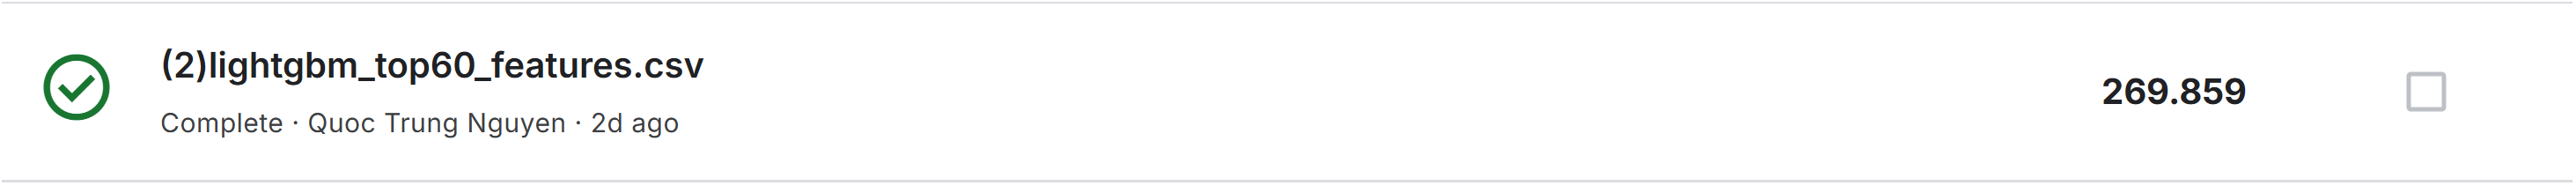

- The LightGBM model with all features achieved a Kaggle **test score of 272.457**.
- Training on the top **60 SHAP-selected** features resulted in a **lower score (269.859)**, indicating improved generalization on unseen data.
- The improvement suggests that removing less important or noisy features helped the model avoid overfitting.
- SHAP-guided feature selection allowed the model to focus on the **most informative** variables.
- Despite using fewer inputs, the model maintained predictive power while enhancing robustness on external data.

#### **5.3 Stacking Models**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# --- STEP 1: Setup placeholders for predictions ---

n_train = X_train_scaled.shape[0]
n_test = X_test_scaled.shape[0]

# Placeholders for OOF training predictions
oof_preds_ridge = np.zeros(n_train)
oof_preds_lasso = np.zeros(n_train)
oof_preds_svr = np.zeros(n_train)
oof_preds_lgbm = np.zeros(n_train)

# Placeholders for final test predictions
test_preds_ridge = np.zeros(n_test)
test_preds_lasso = np.zeros(n_test)
test_preds_svr = np.zeros(n_test)
test_preds_lgbm = np.zeros(n_test)

# --- STEP 2: K-Fold CV for Base Models ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train_scaled):
    # === Prepare data ===
    X_tr_scaled, X_val_scaled = X_train_scaled[train_idx], X_train_scaled[val_idx]
    X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr = y_train.iloc[train_idx]

    # === Train models ===
    best_rdg_model.fit(X_tr_scaled, y_tr)
    best_lso_model.fit(X_tr_scaled, y_tr)
    best_svr_model.fit(X_tr_scaled, y_tr)
    best_lgb.fit(X_tr_raw, y_tr)

    # === Predict on validation fold ===
    oof_preds_ridge[val_idx] = best_rdg_model.predict(X_val_scaled)
    oof_preds_lasso[val_idx] = best_lso_model.predict(X_val_scaled)
    oof_preds_svr[val_idx]   = best_svr_model.predict(X_val_scaled)
    oof_preds_lgbm[val_idx]  = best_lgb.predict(X_val_raw)

# --- STEP 3: Refit all base models on full training data ---
best_rdg_model.fit(X_train_scaled, y_train)
best_lso_model.fit(X_train_scaled, y_train)
best_svr_model.fit(X_train_scaled, y_train)
best_lgb.fit(X_train, y_train)

# --- STEP 4: Predict on test set ---
test_preds_ridge = best_rdg_model.predict(X_test_scaled)
test_preds_lasso = best_lso_model.predict(X_test_scaled)
test_preds_svr   = best_svr_model.predict(X_test_scaled)
test_preds_lgbm  = best_lgb.predict(X_test)

# --- STEP 5: Stack predictions to form input for meta-model ---
stacked_train = np.column_stack([
    oof_preds_ridge,
    oof_preds_lasso,
    oof_preds_svr,
    oof_preds_lgbm
])

stacked_test = np.column_stack([
    test_preds_ridge,
    test_preds_lasso,
    test_preds_svr,
    test_preds_lgbm
])

# --- STEP 6: Train meta-model ---
meta_model = LinearRegression()
meta_model.fit(stacked_train, y_train)

# --- STEP 7: Predict final result on test set ---
final_log_preds = meta_model.predict(stacked_test)
final_price_preds = np.expm1(final_log_preds)  # Inverse log1p

# --- STEP 8: Evaluate on training set ---
stacked_oof_preds = meta_model.predict(stacked_train)

# On log scale
mae_log = mean_absolute_error(y_train, stacked_oof_preds)
r2_log = r2_score(y_train, stacked_oof_preds)

# On price scale
true_price = np.expm1(y_train)
pred_price = np.expm1(stacked_oof_preds)

mae_price = mean_absolute_error(true_price, pred_price)
r2_price = r2_score(true_price, pred_price)

print("Stacking Performance on Training Set:")
print(f"MAE (log scale): {mae_log:.4f}")
print(f"R²   (log scale): {r2_log:.4f}")
print(f"MAE (price): {mae_price:.2f}")
print(f"R²   (price): {r2_price:.4f}")

# --- STEP 9: Export predictions ---
test_output = pd.DataFrame({
    'ID': df_test1['ID'],
    'predicted_price': final_price_preds
})
test_output.to_csv('(16)stacking_ridge_lasso_svr_lgbm.csv', index=False)

**Base Models & Cross-Validation**
- Tuned Ridge, Lasso, SVR, and LightGBM using Optuna for optimal performance.
- Applied 5-fold cross-validation to generate out-of-fold (OOF) predictions and averaged test predictions across folds.
- Used standardized features for linear models, while LightGBM used raw features.

**Stacking Process**
- OOF and test predictions from base models were stacked horizontally to form meta-level datasets.
- A Linear Regression meta-learner was trained on the stacked OOF predictions.
- Final forecasts on the test set were generated using the trained meta-learner.

**Output & Evalutaion**
- Since the target was log-transformed, predictions were **exponentiated (np.expm1)** back to original price scale.
- Model performance evaluated using MAE and R² on both log scale and actual price scale.
- Final predictions exported to a CSV file for Kaggle submission.

#### **5.4 Kaggle Submission Result**

**Output**
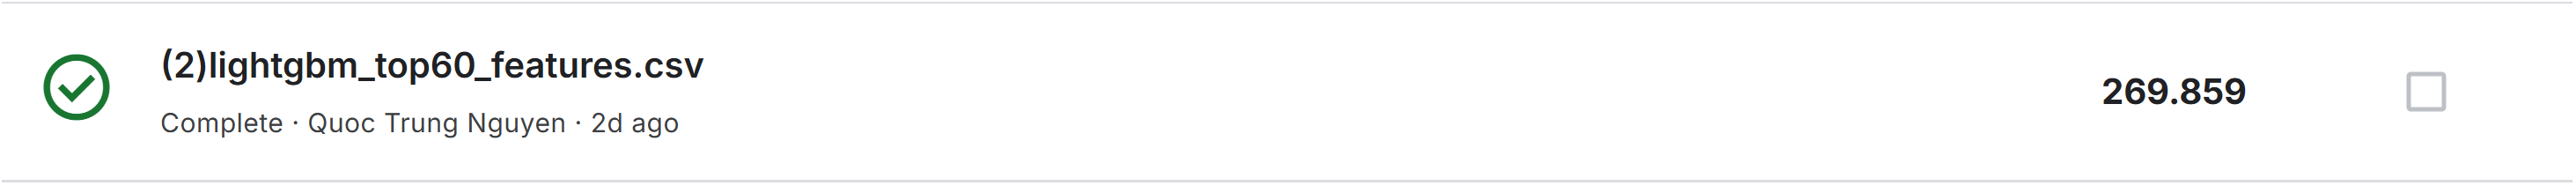

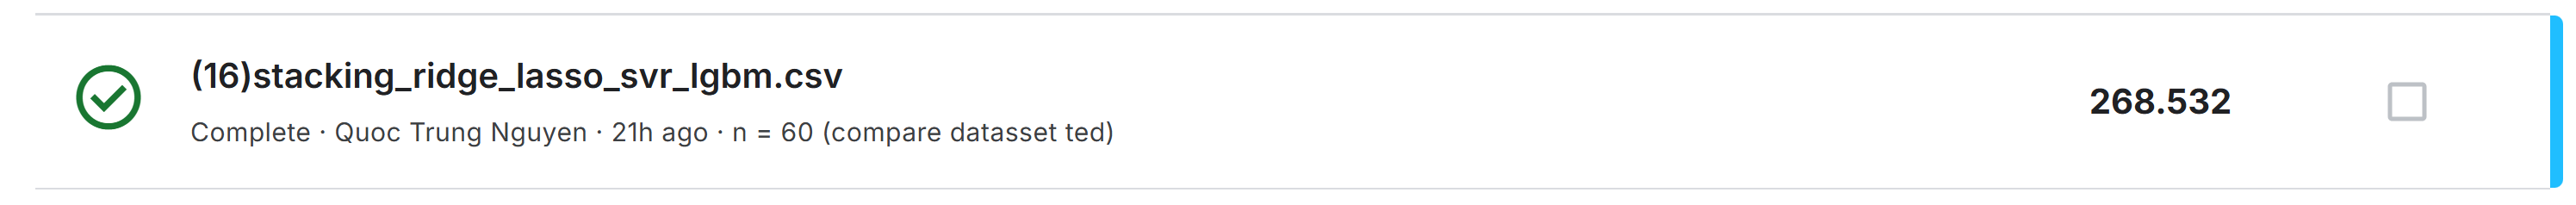

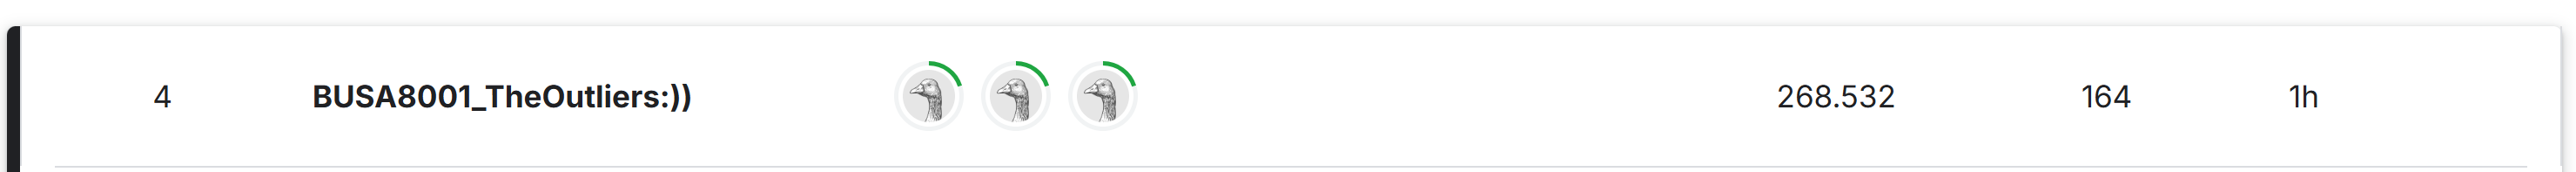

**Performance Results**
- The stacking model achieved a Kaggle score of 268.532, ranking 4th in the competition.
- Outperformed the LightGBM with all features (272.457) and the LightGBM with 60 SHAP-selected features (269.859).

**Comparison with LightGBM (60 features)**
- The SHAP-guided LightGBM reduced overfitting by focusing on the most relevant variables.
- Showed improved generalization compared to the full-feature version.

**Strength of Stacking**
- Combined ***Ridge, Lasso, SVR, and LightGBM*** to leverage complementary model strengths.
- Captured a broader range of data patterns, improving predictive power and robustness.
- Delivered a **lower test error** and stronger generalization, demonstrating the value of stacking over even optimized single models.

### **Final Result** - [View on Kaggle](https://www.kaggle.com/competitions/asba-predictive-analytics-competition/leaderboard)

- **Final Leaderboard Rank:** **3rd out of 106 teams** 🏆  

<div align="center">
  <img src="Final_Results.png" alt="Final Result" width="600"/>
</div>

- **Final Score (Private Leaderboard):** **110.299**  
  - This score represents the **gap between predicted and actual prices**.  
  - A lower score indicates better accuracy, and the trained stacked model performed competitively against other top approaches.
- **Result Recorded:** **6th June 2025, 1:57 PM (AEST)**  